In [3]:
import os
from PIL import Image
import util.image_import as ii
from glob import glob
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras import backend as K
import matplotlib.pyplot as plt
from keras.applications import mobilenet
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, RMSprop, SGD
from util.plots import plot_history
%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


#### Trick to configure gpu memory dynamically

In [4]:
cfg = K.tf.ConfigProto() # Config to dynamically add memory
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))# set this TensorFlow session as the default session for Keras.

### Subtracting mean and normalizing

In [11]:
mean_image_train = ii.calulate_mean("../dataset3/res_still/train")

def subtract_mean(img):
    return img - mean_image_train

In [17]:
train_path = '../dataset3/res_still/train'
test_path = '../dataset3/res_still/test'

batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        vertical_flip=True,
        horizontal_flip=True,
        brightness_range=(0.65, 1.35),
        preprocessing_function=subtract_mean)

test_datagen = ImageDataGenerator(
        rescale=1./255,
        preprocessing_function=subtract_mean)

# Train data generator
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=batch_size)

# Validation data generator
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=batch_size)

Found 1875 images belonging to 8 classes.
Found 472 images belonging to 8 classes.


## Optimized model single run <span style="color:red"> Done but maybe not converging</span>

In [19]:
model_optimized = Sequential()
model_optimized.add(Flatten(input_shape=(224,224,3)))
model_optimized.add(Dense(256))
model_optimized.add(Activation('relu'))
model_optimized.add(Dense(8))
model_optimized.add(Activation('softmax'))
model_optimized.compile(loss='categorical_crossentropy',
                        optimizer=Adam(lr=1e-4),
                        metrics=['accuracy'])

model_optimized.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               38535424  
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 2056      
_________________________________________________________________
activation_4 (Activation)    (None, 8)                 0         
Total params: 38,537,480
Trainable params: 38,537,480
Non-trainable params: 0
_________________________________________________________________


In [20]:
history_optimized = model_optimized.fit_generator(
                    train_generator,
                    steps_per_epoch=1875 // batch_size,
                    epochs=100,
                    validation_data=test_generator,
                    validation_steps=472 // batch_size,
                    use_multiprocessing=True,
                    workers=4)


Epoch 1/100
58/58 [==============================] - 32s 549ms/step - loss: 2.7658 - acc: 0.2174 - val_loss: 1.6083 - val_acc: 0.4196
Epoch 2/100
58/58 [==============================] - 31s 538ms/step - loss: 2.2195 - acc: 0.3145 - val_loss: 1.4601 - val_acc: 0.4397
Epoch 3/100
58/58 [==============================] - 33s 567ms/step - loss: 2.1396 - acc: 0.3253 - val_loss: 1.2709 - val_acc: 0.4955
Epoch 4/100
58/58 [==============================] - 33s 563ms/step - loss: 2.0815 - acc: 0.3440 - val_loss: 1.2729 - val_acc: 0.4978
Epoch 5/100
58/58 [==============================] - 32s 551ms/step - loss: 1.8489 - acc: 0.4054 - val_loss: 1.2504 - val_acc: 0.5379
Epoch 6/100
58/58 [==============================] - 34s 593ms/step - loss: 1.7950 - acc: 0.4196 - val_loss: 1.2525 - val_acc: 0.5290
Epoch 7/100
58/58 [==============================] - 33s 572ms/step - loss: 1.6871 - acc: 0.4437 - val_loss: 1.1892 - val_acc: 0.5513
Epoch 8/100
58/58 [==============================] - 30s 525ms

Epoch 62/100
58/58 [==============================] - 35s 597ms/step - loss: 0.6505 - acc: 0.7889 - val_loss: 0.7899 - val_acc: 0.7857
Epoch 63/100
58/58 [==============================] - 34s 582ms/step - loss: 0.7506 - acc: 0.7640 - val_loss: 0.7168 - val_acc: 0.7991
Epoch 64/100
58/58 [==============================] - 33s 573ms/step - loss: 0.6684 - acc: 0.7862 - val_loss: 0.7231 - val_acc: 0.8036
Epoch 65/100
58/58 [==============================] - 33s 567ms/step - loss: 0.7820 - acc: 0.7748 - val_loss: 0.7868 - val_acc: 0.7857
Epoch 66/100
58/58 [==============================] - 31s 542ms/step - loss: 0.7944 - acc: 0.7472 - val_loss: 0.7454 - val_acc: 0.8058
Epoch 67/100
58/58 [==============================] - 32s 549ms/step - loss: 0.8004 - acc: 0.7654 - val_loss: 0.7387 - val_acc: 0.8103
Epoch 68/100
58/58 [==============================] - 32s 545ms/step - loss: 0.7288 - acc: 0.7800 - val_loss: 0.7229 - val_acc: 0.8080
Epoch 69/100
58/58 [==============================] - 3

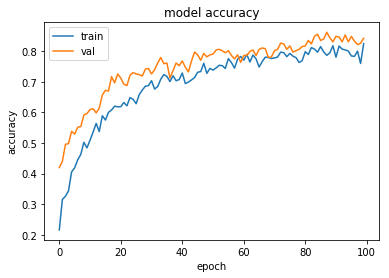

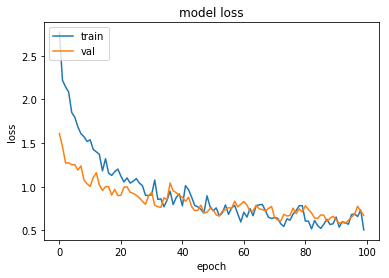

In [21]:
plot_history(history_optimized, save=True, path='nets/feedforward/', name='plot_full')